In [4]:
import functions
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.signal import  filtfilt, butter, iirnotch, savgol_filter, find_peaks, sosfilt
from sklearn.decomposition import FastICA as skFastICA
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB
from picard import Picard

In [5]:
no_ica_chans = 18
fs=1000
span = 3000
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 

In [12]:
def bandpass_filter(dd, order=5):
    bandpass = butter(order, [1, 80], btype='band', output='sos', fs=1000)
    b_notch, a_notch = iirnotch(50, 40, fs=1000)
    data = deepcopy(dd)
    for i in range(data.shape[1]):
        data[:,i] = sosfilt(bandpass, data[:,i])
        data[:,i] = filtfilt(b_notch, a_notch, data[:,i])
    return data

In [13]:
dd = functions.array_from_TDMSgroup("patients/P048/P048_S01_D2024-06-06_G26.tdms", "R001")
filtered_data = bandpass_filter(dd[1000:, 1:]).T

### Block 1: FastICA with 18 components --> S_ (sources), A_(mixing matrix)

In [65]:
ica = skFastICA(n_components=None, fun='logcosh', max_iter=400, tol=1e-5)
sources = ica.fit_transform(filtered_data.T)
mixing = ica.mixing_

In [67]:
mixing.shape

(32, 32)

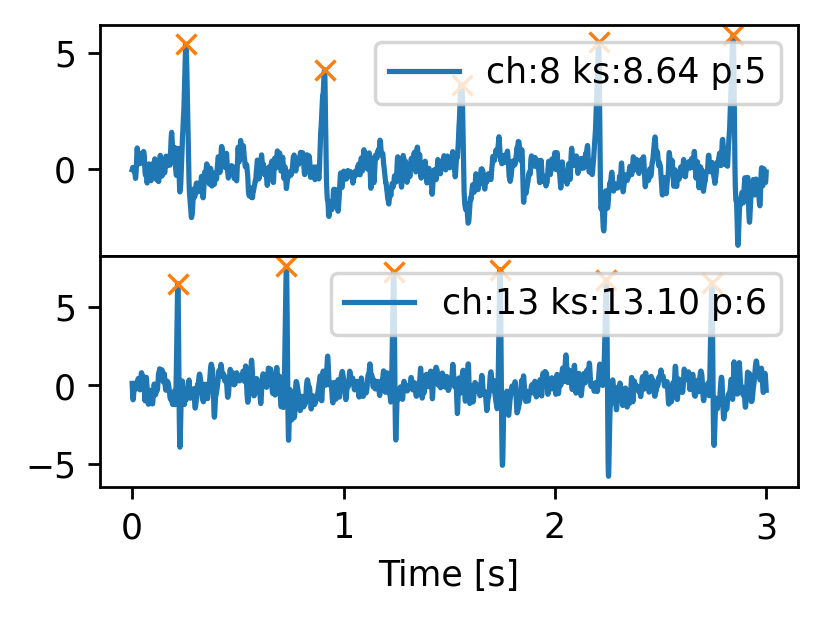

In [66]:
kurtosis_values = [stats.kurtosis(sources[offset:(offset + span), j]) for j in range(sources.shape[1])]
channels_to_plot = [j for j, kurt in enumerate(kurtosis_values) if kurt > 1.70]

# Set up the subplot grid based on the number of channels to plot
fig, ax = plt.subplots(len(channels_to_plot), 1, sharex=True, figsize=(1.8 * len(channels_to_plot), 1.2 * len(channels_to_plot)), dpi=250)
fig.subplots_adjust(hspace=0)

# Plot only the channels with kurtosis > 2
for i, j in enumerate(channels_to_plot):
    signal = sources[offset:offset+span, j]
    peaks, properties = find_peaks(np.abs(signal), distance = 400, height=2) 
    ax[i].plot(sources[offset:offset+span, j], label=f'ch:{j} ks:{kurtosis_values[j]:.2f} p:{len(peaks)}')
    ax[i].plot(peaks, signal[peaks], "x")
    ax[i].legend(loc=1)

# Configure the x-axis formatter for the last subplot
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')

# Display the plot
plt.show()

### Block 2: kurtosis thresholding, from what I observe the kurtosis values higher than 1.7 are generally in a peaky shape and they are either maternal or fetal component, see mixing_analysis.ipynb for this.

### Block 3: peaks thresholding, for a span of 10 000, we can see that maternal_peaks are approximately 15 or 16, so we can use this idea to seperate the maternal components from fetal components

for candidate 8, found number of peaks 5
for candidate 13, found number of peaks 6
found maternal indices: {8: array([ 254,  910, 1560, 2206, 2842])} and found fetal indices {13: array([ 216,  730, 1237, 1740, 2242, 2742])}


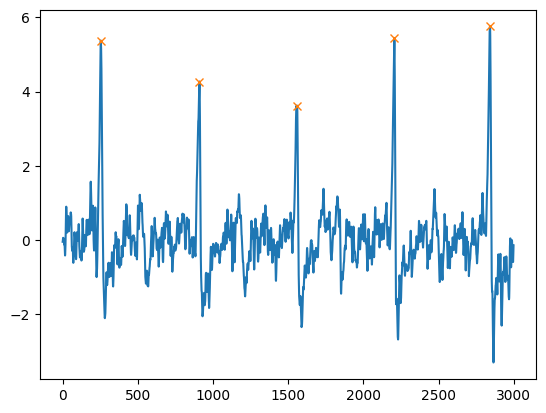

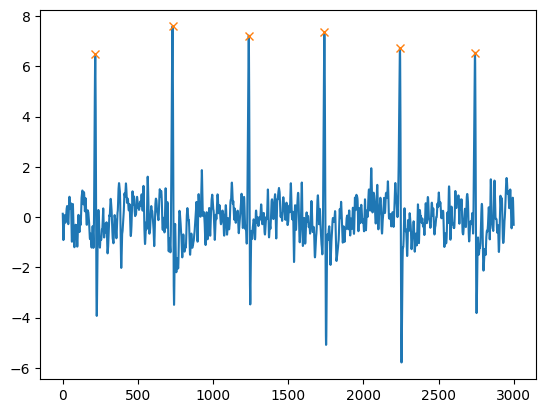

In [68]:
def determine_components(source_matrix, indices, peak_threshold = 6):
    fetal_indices = {}
    maternal_indices = {}
    for index in indices:
        candidate = source_matrix[offset:(offset+span), index]
        peaks, properties = find_peaks(np.abs(candidate), prominence = 2, distance = 400) 
        plt.figure()
        plt.plot(candidate)
        plt.plot(peaks, candidate[peaks], "x")
        print(f"for candidate {index}, found number of peaks {len(peaks)}")
        if len(peaks) > peak_threshold:
            fetal_indices[index] = peaks
        else:
            maternal_indices[index] = peaks
            
    return fetal_indices, maternal_indices

fet, mat = determine_components(sources, channels_to_plot, peak_threshold = 5)
print(f"found maternal indices: {mat} and found fetal indices {fet}")

### Block 4: Eleminating directly the fetal components from the mixing matrix obtained from previous block
This part is a bit problematic since fetal components can also include maternal interference

In [ ]:
A_maternal = deepcopy(mixing)
for fet_index in fet.keys():
        A_maternal[:, fet_index] = 0

### Block 5: from Block 3, we get the maternal components but we should eleminate the fetal parts in maternal so that in the subtraction part we don't substract any fetal part.

In [ ]:
from scipy.interpolate import CubicSpline

def upDownSample(source_matrix, maternal_indices, downsample_factor_qrs=5, downsample_factor_other=20):
    maternal_matrix = deepcopy(source_matrix)

    for index in maternal_indices.keys():
        candidate = maternal_matrix[offset:(offset+span), index]
        peak_indices = maternal_indices[index]
        
        # Create a mask for downsampling
        downsample_mask = np.zeros_like(candidate, dtype=bool)
        
        for peak in peak_indices:
            start_qrs = max(0, peak - 50)
            end_qrs = min(len(candidate), peak + 50)
            downsample_mask[start_qrs:end_qrs] = True
        
        # Downsample
        downsampled_signal = []
        indices = []
        for i in range(len(candidate)):
            if downsample_mask[i]:
                if i % downsample_factor_qrs == 0:
                    downsampled_signal.append(candidate[i])
                    indices.append(i)
            else:
                if i % downsample_factor_other == 0:
                    downsampled_signal.append(candidate[i])
                    indices.append(i)
        
        # Convert to numpy arrays
        downsampled_signal = np.array(downsampled_signal)
        indices = np.array(indices)
        
        # Perform cubic spline interpolation
        cs = CubicSpline(indices, downsampled_signal)
        upsampled_signal = cs(np.arange(len(candidate)))
        
        # Replace the original signal with the upsampled signal
        maternal_matrix[offset:(offset+span), index] = upsampled_signal
    
    return maternal_matrix

maternal_matrix = upDownSample(sources, mat)

fig, ax = plt.subplots(maternal_matrix.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(maternal_matrix.shape[1]):
    ax[j].plot(maternal_matrix[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### Block 6: now having maternal_matrix, which are the maternal source components, S_maternal, we can construct the maternal channels by using the mixing matrix with fetal components deleted

In [ ]:
reconstructed_maternal = np.dot(maternal_matrix, A_maternal.T)

fig, ax = plt.subplots(reconstructed_maternal.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(reconstructed_maternal.shape[1]):
    ax[j].plot(reconstructed_maternal[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

In [ ]:
onlyFetal = filtered_data[5000:,1:] - reconstructed_maternal

fig, ax = plt.subplots(onlyFetal.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250)
fig.subplots_adjust(hspace=0)

for j in range(onlyFetal.shape[1]):
    ax[j].plot(onlyFetal[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

In [ ]:
plt.plot(savgol_filter(onlyFetal[offset+300:(offset + 500), 20],25,3))

In [ ]:
ms2s = lambda x, _:f'{x/1000:g}' 
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))

components_hos = np.zeros_like(onlyFetal)
for channel in range(onlyFetal.shape[1]):
    beat, detect = apply_hosd(onlyFetal[:,channel], window_size) 
    components_hos[:,channel] = detect


In [ ]:
fig, ax = plt.subplots(onlyFetal.shape[1], 1, sharex=True, figsize=(18 / 2.54, 36 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(onlyFetal.shape[1]):
    ax[j].plot(components_hos[offset:(offset + span), j], label=f"{stats.kurtosis(components_hos[offset:(offset + span), j]):.2f}")
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()